# imports

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from IPython.display import clear_output

import tqdm
from tqdm.notebook import tqdm as tqdm_notebook

import numpy as np

from copy import deepcopy

# LeNet

In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.flatten = nn.Flatten()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),   # [28x28x6]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),       # [14x14x6]
            nn.Conv2d(6, 16, kernel_size=5),             # [10x10x16]
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)        # [5x5x16]
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(5*5*16, 120),                      # [120]
            nn.Sigmoid(),
            nn.Linear(120, 84),                          # [84]
            nn.Sigmoid(),
            nn.Linear(84, 10)                            # [10]
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)        # [400]  
        x = self.fc_layers(x)
        x = F.log_softmax(x, dim=1)        
        return x

# learning_function()

In [16]:
# функция отрисовки метрик, принимает словарь метрик - ошибка и accuracy на тренироввочном наборе данных
def plot_metrics(metrics: dict) -> None:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    train_loss, test_loss, train_acc, test_acc = metrics.values()

    axes[0].set_title(f'Train loss: {train_loss[-1]:.2f}, Test loss: {test_loss[-1]:.2f}')
    axes[0].plot(train_loss, label='Train_loss')
    axes[0].plot(test_loss, label='Test_loss')

    axes[1].set_title(f'Train acc: {train_acc[-1]:.2f}, Test acc: {test_acc[-1]:.2f}')
    axes[1].plot(train_acc, label='Train_acc')
    axes[1].plot(test_acc, label='Test_acc')

    legend = [ax.legend() for ax in axes]
    fig.legend = legend
    plt.show()

In [ ]:
def learning_function(model, train_loader, test_loader, 
                      epochs=10, learning_rate=0.001, device='auto'):
    
    metrics = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': []}
    
    # Определение устройства
    if device == 'auto':
        device_for_learning = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    elif device == 'cpu':
        device_for_learning = torch.device("cpu")
    elif device == 'gpu':
        device_for_learning = torch.device("gpu")
    else:
        raise ValueError("Invalid device choice. Use 'auto', 'cpu', or 'gpu'.")

    model.to(device_for_learning)

    loss_func = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # Не знаем что взять - пробуем Adam
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Планировщик скорости обучения

    # Цикл обучения
    for epoch in range(epochs):
        loss_epoch, acc_epoch = 0, 0
        len_dataset = len(train_loader.dataset)
        
        for data, target in train_loader: #tqdm_notebook(train_loader, desc='Train', leave=False): 
            #print(data.shape, target.shape)
            # переместить данные и таргеты на устройство для обучения
            data, target = data.to(device_for_learning), target.to(device_for_learning)

            # пропустить данные через модель и посчитать ошибку
            logits = model(data)
            loss = loss_func(logits, target)

            # обучение сети
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # так как ошибка усредняется по батчу, делаем обратную денормировку
            # чтобы потом просто разделить на длину датасета
            loss_epoch += loss.item() * target.size(0)
            acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()        

        metrics['train_loss'].append(loss_epoch / len_dataset)
        metrics['train_acc'].append(acc_epoch / len_dataset)
        
        # Валидация
        loss_epoch, acc_epoch  = 0, 0
        len_dataset = len(test_loader.dataset)        
        with torch.inference_mode():
            for data, target in test_loader: #tqdm_notebook(test_loader, desc='Validation', leave=False): 
                # переместить данные и таргеты на устройство для обучения
                data, target = data.to(device_for_learning), target.to(device_for_learning)

                # пропустить данные через модель и посчитать ошибку
                logits = model(data)
                loss = loss_func(logits, target)


                loss_epoch += loss.item() * target.size(0)
                acc_epoch += torch.sum(logits.argmax(dim=1) == target).item()

        metrics['test_loss'].append(loss_epoch / len_dataset)
        metrics['test_acc'].append(acc_epoch / len_dataset)

        # отрисовка графиков
        clear_output(True)
        plot_metrics(metrics)

    # Сохранение модели
    # torch.save(model.state_dict(), "lenet_fashionmnist.pth")



# Загрузка датасета, настройка параметров

In [18]:
# Гиперпараметры
BATCH_SIZE = 128
#EPOCHS = 15
#LEARNING_RATE = 0.005
torch.manual_seed(42)

# Трансформации для данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Статистика FashionMNIST
])

### Реализация DS

In [19]:
# Загрузка FashionMNIST
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


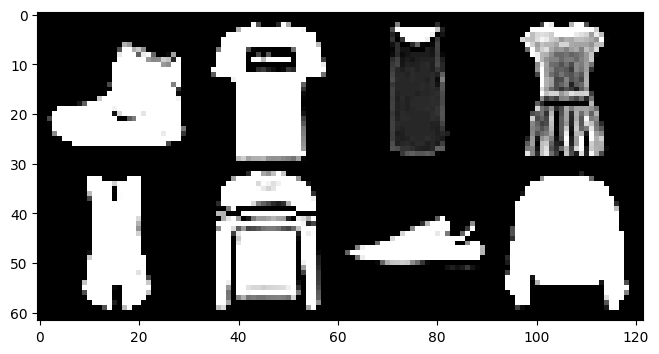

In [20]:
# картинка из 8 примеров датасета, соединенных через make_grid
grid = make_grid([train_dataset[i][0] for i in range(8)], nrow=4)

plt.figure(figsize=(15, 4))
plt.imshow(grid.permute(1, 2, 0));

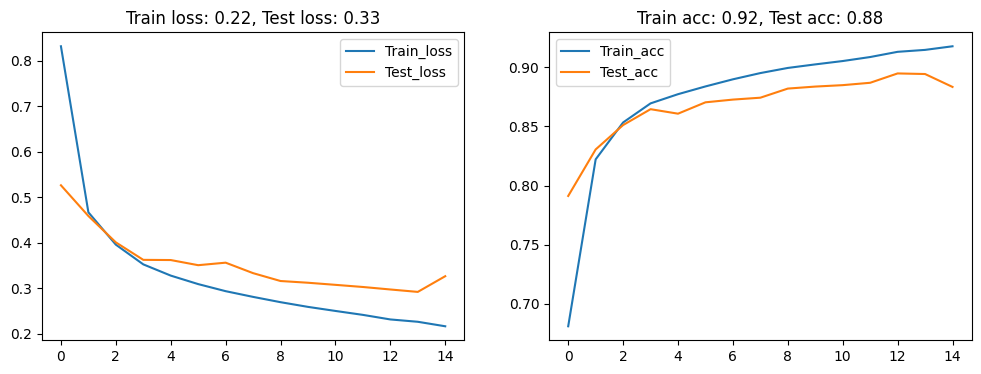

In [21]:
learning_function(LeNet(), train_loader, test_loader, epochs=15, learning_rate=0.005, device='auto')

In [9]:
print(train_loader.dataset)
print(test_loader.dataset)
print(train_loader.dataset.data.shape, train_loader.dataset.data.sum())

# Сбор всех данных в один тензор
data = torch.cat([img for img, _ in train_loader.dataset], dim=0)

# Расчет среднего и std
mean = data.mean().item()
std = data.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )
torch.Size([60000, 28, 28]) tensor(3431114169)
Mean: 0.0001, Std: 1.0001


### Реализация HW

In [10]:
# Загрузка датасета
fashion_mnist_dataset = datasets.FashionMNIST(root="fashion",  
                                              train=True,
                                              download=True, 
                                              transform=transform)
# Содержит 60000 семплов и 10 классов
images = fashion_mnist_dataset.data.view([60000, 1, 28, 28]).float()

labels = deepcopy(fashion_mnist_dataset.targets)# - 1

X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.01)

train_data = TensorDataset(X_train, y_train)
val_data = TensorDataset(X_val, y_val)
batch_size = 128

train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=len(val_data))

In [11]:
print(fashion_mnist_dataset)
print(fashion_mnist_dataset.data.shape, fashion_mnist_dataset.data.sum())

import numpy as np

# Сбор всех данных в один тензор
data = torch.cat([img for img, _ in fashion_mnist_dataset], dim=0)

# Расчет среднего и std
mean = data.mean().item()
std = data.std().item()

print(f"Mean: {mean:.4f}, Std: {std:.4f}")

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashion
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.286,), std=(0.353,))
           )
torch.Size([60000, 28, 28]) tensor(3431114169)
Mean: 0.0001, Std: 1.0001


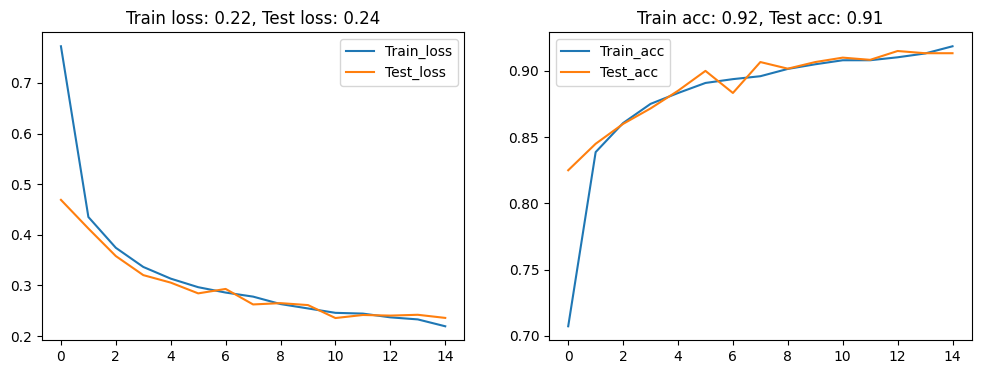

In [12]:
learning_function(LeNet(), train_dl, val_dl, epochs=15, learning_rate=0.005, device='auto')

# Обучение моделей

In [ ]:
#model = LeNet(how_inizialize='relu')
#learning_function(model, train_loader, test_loader, epochs=10, learning_rate=0.005, device='cpu')

In [ ]:
#model = LeNet(how_inizialize='sigmoid')
#learning_function(model, train_loader, test_loader, epochs=10, learning_rate=0.005, device='auto')